## Dependencies

In [1]:
import pandas as pd
import numpy as np
import os
import glob

import matplotlib.pyplot as plt
# plt.rcParams['figure.figsize'] = (15, 5)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


In [2]:
indataPath = os.path.join(os.pardir, "indata")

ddfRootPath = os.path.join(indataPath, "ddf--sodertornsmodellen")
ddfSrcPath = os.path.join(ddfRootPath, "ddf--sodertornsmodellen--src")

superPath = os.path.join(indataPath, "supermappen")

ddfOutputPath = os.path.join(os.pardir, 'ddf--sodertornsmodellen-new', 'ddf--sodertornsmodellen--src')

## Helpers

In [3]:
from helpers import (readMaster, appendNewDatapoints, byGender, baskod2010tobasomrade, plotcombined)

## Läs in MASTER excel filen

In [4]:
master = readMaster()

## Kombinera `.csv` med MASTER 

In [5]:
csv = pd.read_csv('../indata/supermappen/Tabell2A_FB7bas.csv', encoding='latin1' , sep=';', decimal=',')
csv['year'] = pd.to_datetime('2017')
csv = csv.rename(columns={
    "Basomrade": "BASKOD2010",
    "Hyresrätt": "antal_hyres",
    "Bostadsrätt": "antal_bostadsr",
    "Äganderätt": "antal_aegender",
    "Uppgift_saknas": "Lght_Uppgift saknas",
    "TOTALT": "Lght total"
})

subsetmas = master[['BASKODER','year', 'Lght_Hyresrätt', 'Lght_Bostadsrätt','Lght_Äganderätt','Lght_Uppgift saknas','Lght total']]
subsetmas = subsetmas.rename(columns = {
    "Lght_Hyresrätt": "antal_hyres",
    "Lght_Bostadsrätt": "antal_bostadsr",
    "Lght_Äganderätt": "antal_aegender"
})

In [6]:
mas2012 = subsetmas[subsetmas['year'] >= pd.to_datetime('2012')]
mas2012 = mas2012.rename(columns = {
    'BASKODER': 'BASKOD2010'
})

In [7]:
concat = pd.concat([csv, mas2012], sort=False)

## Summera efter år och Basområde2000 kod

In [8]:
concat = concat[['BASKOD2010', 'year', 'antal_hyres', 'antal_bostadsr', 'antal_aegender', 'Lght_Uppgift saknas', 'Lght total']]

In [9]:
merged = baskod2010tobasomrade(concat, n_numeric=5)

In [10]:
concat.head()

,BASKOD2010,year,antal_hyres,antal_bostadsr,antal_aegender,Lght_Uppgift saknas,Lght total
0,1010110,2017-01-01,13.0,0.0,0.0,0.0,13.0
1,1010120,2017-01-01,184.0,100.0,0.0,0.0,284.0
2,1010130,2017-01-01,372.0,294.0,0.0,0.0,666.0
3,1010140,2017-01-01,657.0,348.0,8.0,0.0,1013.0
4,1010201,2017-01-01,76.0,150.0,0.0,0.0,226.0


In [11]:
merged.head()

,year,basomrade,antal_hyres,antal_bostadsr,antal_aegender,Lght_Uppgift saknas,Lght total
0,2012-01-01,1010120_skeppsbron,184.0,89.0,0.0,0.0,273.0
1,2012-01-01,1010130_munkbron,364.0,253.0,0.0,0.0,617.0
2,2012-01-01,1010140_stortorget,606.0,350.0,8.0,0.0,964.0
3,2012-01-01,1010201_centralstationen_n,76.0,145.0,0.0,0.0,221.0
4,2012-01-01,1010220_klara_kyrka,15.0,59.0,0.0,0.0,74.0


In [12]:
# sum values by year and baskod2000
subset = merged[['year', 'basomrade', 'antal_hyres', 'antal_bostadsr', 'antal_aegender', 'Lght total']]
summed = pd.DataFrame(subset.groupby(['year','basomrade']).sum()).reset_index()

In [13]:
summed['year'] = summed['year'].apply(lambda t: t.year)

In [14]:
# ta bort rader som saknar data
# summed = summed.dropna(how='any')

In [15]:
summed[['year', 'Lght total']].groupby('year').sum()

,Lght total
year,
2012,943331.0
2013,950892.0
2014,959773.0
2015,971836.0
2016,990371.0
2017,1028961.0


In [16]:
df = summed

## Andelar

#### Andel hyresrätter

In [17]:
concept = 'andel_hyres'

In [18]:
summed['andel_hyres'] = summed['antal_hyres'] / summed['Lght total']
summed['andel_hyres'] = summed['andel_hyres'].round(4)
summed['andel_hyres'] = summed['andel_hyres'].astype(str).replace('0.0', '0')
summed['andel_hyres'] = summed['andel_hyres'].astype(str).replace('1.0', '1')
summed['andel_hyres'] = summed['andel_hyres'].astype(str).replace('nan', '')

In [19]:
out = summed[['basomrade', 'year', 'andel_hyres']]
out.to_csv(os.path.join(ddfOutputPath, 'ddf--datapoints--andel_hyres--by--basomrade--year.csv'), index=False)

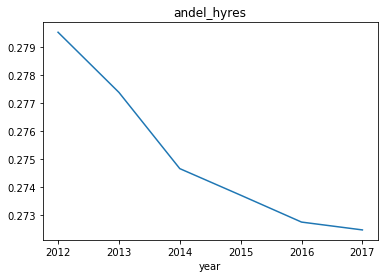

In [20]:
out = out[out[concept] != '']
out[concept] = out[concept].astype(float)
out['year'] = pd.to_datetime(out['year'].astype('str'))
(out.groupby('year').mean()[concept]).plot(title=concept)

#### Andel bostadsrätter

In [21]:
concept = 'andel_bostadsr'

In [22]:
summed['andel_bostadsr'] = summed['antal_bostadsr'] / summed['Lght total']
summed['andel_bostadsr'] = summed['andel_bostadsr'].round(4)
summed['andel_bostadsr'] = summed['andel_bostadsr'].astype(str).replace('0.0', '0')
summed['andel_bostadsr'] = summed['andel_bostadsr'].astype(str).replace('1.0', '1')
summed['andel_bostadsr'] = summed['andel_bostadsr'].astype(str).replace('nan', '')

In [23]:
out = summed[['basomrade', 'year', 'andel_bostadsr']]
out.to_csv(os.path.join(ddfOutputPath, 'ddf--datapoints--andel_bostadsr--by--basomrade--year.csv'), index=False)

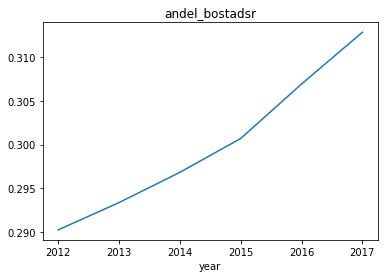

In [24]:
out = out[out[concept] != '']
out[concept] = out[concept].astype(float)
out['year'] = pd.to_datetime(out['year'].astype('str'))
(out.groupby('year').mean()[concept]).plot(title=concept)

#### Andel äganderätter

In [25]:
concept = 'andel_aegender'

In [26]:
summed['andel_aegender'] = summed['antal_aegender'] / summed['Lght total']
summed['andel_aegender'] = summed['andel_aegender'].round(4)
summed['andel_aegender'] = summed['andel_aegender'].astype(str).replace('0.0', '0')
summed['andel_aegender'] = summed['andel_aegender'].astype(str).replace('1.0', '1')
summed['andel_aegender'] = summed['andel_aegender'].astype(str).replace('nan', '')

In [27]:
out = summed[['basomrade', 'year', 'andel_aegender']]
out.to_csv(os.path.join(ddfOutputPath, 'ddf--datapoints--andel_aegender--by--basomrade--year.csv'), index=False)

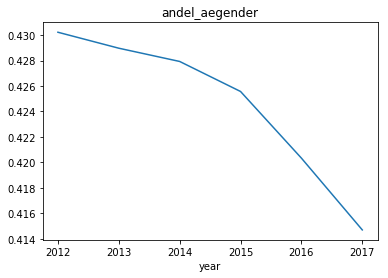

In [28]:
out = out[out[concept] != '']
out[concept] = out[concept].astype(float)
out['year'] = pd.to_datetime(out['year'].astype('str'))
(out.groupby('year').mean()[concept]).plot(title=concept)

## Antal

#### Andel hyresrätter

In [38]:
concept = 'antal_hyres'

In [39]:
out = df[['basomrade', 'year', 'antal_hyres']].copy()
out.to_csv(os.path.join(ddfOutputPath, 'ddf--datapoints--antal_hyres--by--basomrade--year.csv'), index=False)

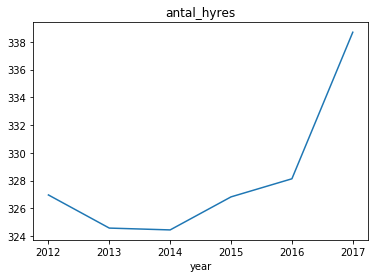

In [40]:
out[concept] = out[concept].astype(float)
out['year'] = pd.to_datetime(out['year'].astype('str'))
(out.groupby('year').mean()[concept]).plot(title=concept)

#### Andel bostadsrätter

In [41]:
concept = 'antal_bostadsr'

In [42]:
out = df[['basomrade', 'year', 'antal_bostadsr']].copy()
out.to_csv(os.path.join(ddfOutputPath, 'ddf--datapoints--antal_bostadsr--by--basomrade--year.csv'), index=False)

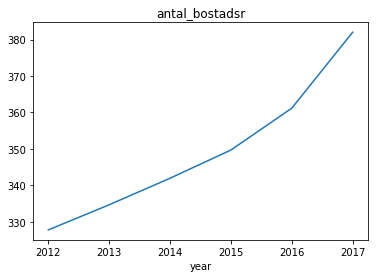

In [43]:
out[concept] = out[concept].astype(float)
out['year'] = pd.to_datetime(out['year'].astype('str'))
(out.groupby('year').mean()[concept]).plot(title=concept)

#### Andel äganderätter

In [44]:
concept = 'antal_aegender'

In [45]:
out = df[['basomrade', 'year', 'antal_aegender']].copy()
out.to_csv(os.path.join(ddfOutputPath, 'ddf--datapoints--antal_aegender--by--basomrade--year.csv'), index=False)

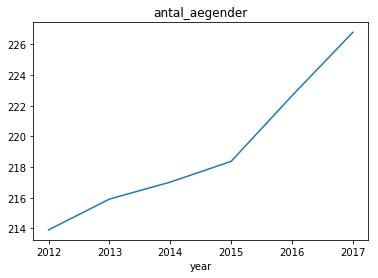

In [46]:
out[concept] = out[concept].astype(float)
out['year'] = pd.to_datetime(out['year'].astype('str'))
(out.groupby('year').mean()[concept]).plot(title=concept)